In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
from cartopy.util import add_cyclic_point
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


## Read in data 

In [2]:
dataDir = '/glade/derecho/scratch/mdfowler/archive/'

caseNames = ['FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cesm2_3_alpha17b_gustsOFF.U10scToAtm.006_ctrl_moreOutput',
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cesm2_3_alpha17b_gustsOFF.U10scToAtm.006_moreOutput',
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cesm2_3_alpha17b_gustsOFF.U10scToAtm.006_forceU10resSmall', 
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cesm2_3_alpha17b_gustsOFF.U10scToAtm.006_U10eqCtrl',
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cesm2_3_alpha17b_gustsOFF.U10scToAtm.007_u10sc',
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cesm2_3_alpha17b_gustsOFF.U10scToAtm.008_u10sc', 
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cesm2_3_alpha17b_gustsOFF.U10scToAtm.009_u10sc', 
            ]

case_IDs = ['Calc_U10n', 'Calc_U10sc', 'Force_U10eq0p5', 'TryCtrlCalcAgain?', 
            'Calc_U10sc_initSC', 'Calc_U10sc_initHOL', 'Calc_U10sc_initPSI']


In [3]:
for iCase in range(len(case_IDs)):
    # print('*** Starting on case %s ***' % (case_IDs[iCase]))

    ## Get list of files 
    listFiles_h2 = np.sort(glob.glob(dataDir+caseNames[iCase]+'/atm/hist/*cam.h2i.00??-*'))
    
    ## Now read in those files    
    case_h2 = xr.open_mfdataset(listFiles_h2, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
        
    ## Add case ID (short name) to the DS
    case_h2      = case_h2.squeeze().assign_coords({"case":  case_IDs[iCase]})

    print(case_IDs[iCase], ' .... TimeEnd = ', case_h2.isel(time=-1).time.values)
    
    ## Return all the cases in a single dataset  
    if iCase==0:
        h2_testU10 = case_h2
    else: 
        h2_testU10 = xr.concat([h2_testU10, case_h2], "case") 


Calc_U10n  .... TimeEnd =  0001-01-04 00:00:00
Calc_U10sc  .... TimeEnd =  0001-01-04 00:00:00
Force_U10eq0p5  .... TimeEnd =  0001-01-04 00:00:00
TryCtrlCalcAgain?  .... TimeEnd =  0001-01-04 00:00:00
Calc_U10sc_initSC  .... TimeEnd =  0001-01-04 00:00:00
Calc_U10sc_initHOL  .... TimeEnd =  0001-01-04 00:00:00
Calc_U10sc_initPSI  .... TimeEnd =  0001-01-02 00:00:00


In [4]:
listFiles_h0 = np.sort(glob.glob(dataDir+caseNames[-1]+'/atm/hist/*cam.h0i.00??-*'))
case_h0 = xr.open_mfdataset(listFiles_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
        

In [5]:
h2_testU10

<xarray.Dataset>
Dimensions:       (lat: 192, lon: 288, lev: 58, ilev: 59, trop_cld_lev: 58,
                   time: 144, case: 7, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.3 357.5 358.8
  * lev           (lev) float64 3.018 5.445 9.087 14.25 ... 983.2 991.2 997.5
  * ilev          (ilev) float64 2.055 3.98 6.909 11.27 ... 987.4 995.1 1e+03
  * trop_cld_lev  (trop_cld_lev) float64 3.018 5.445 9.087 ... 983.2 991.2 997.5
  * time          (time) object 0001-01-01 00:30:00 ... 0001-01-04 00:00:00
  * case          (case) <U18 'Calc_U10n' 'Calc_U10sc' ... 'Calc_U10sc_initPSI'
Dimensions without coordinates: nbnd
Data variables: (12/32)
    w             (case, lat) float64 dask.array<chunksize=(1, 192), meta=np.ndarray>
    hyam          (case, lev) float64 dask.array<chunksize=(1, 58), meta=np.ndarray>
    hybm          (case, lev) float64 dask.array<chunksize=(1, 58), meta=np.ndarray>
    hyai          (case, ilev) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    hybi          (case, ilev) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    date          (case, time) float64 dask.array<chunksize=(1, 48), meta=np.ndarray>
    ...            ...
    TAUX          (case, time, lat, lon) float32 dask.array<chunksize=(1, 48, 192, 288), meta=np.ndarray>
    TAUY          (case, time, lat, lon) float32 dask.array<chunksize=(1, 48, 192, 288), meta=np.ndarray>
    U10           (case, time, lat, lon) float32 dask.array<chunksize=(1, 48, 192, 288), meta=np.ndarray>
    UBOT          (case, time, lat, lon) float32 dask.array<chunksize=(1, 48, 192, 288), meta=np.ndarray>
    UGUST         (case, time, lat, lon) float32 dask.array<chunksize=(1, 48, 192, 288), meta=np.ndarray>
    VBOT          (case, time, lat, lon) float32 dask.array<chunksize=(1, 48, 192, 288), meta=np.ndarray>
Attributes:
    interp_type:       bilinear
    interp_outputgri:  equally spaced with poles
    Conventions:       CF-1.0
    source:            CAM
    case:              FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_ces...
    logname:           mdfowler
    host:              derecho1
    initial_file:      f.cam6_3_107.FLTHIST_v0a.ne30.clm5_1.001.cam.i.1994-01...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/s...
    model_doi_url:     not_set
    time_period_freq:  minute_30

## Timeseries plots?

In [29]:
## Make sure can take weighted mean for globe
weights = np.cos(np.deg2rad(h2_testU10.lat))
weights.name = "weights"

globalLHFLX   = h2_testU10['LHFLX'].weighted(weights).mean(("lon","lat"))
globalUBOT    = h2_testU10['UBOT'].weighted(weights).mean(("lon","lat"))
globalU10     = h2_testU10['U10'].weighted(weights).mean(("lon","lat"))
globalTAUX    = h2_testU10['TAUX'].weighted(weights).mean(("lon","lat"))


Text(0.5, 1.0, 'Global Mean UBOT')

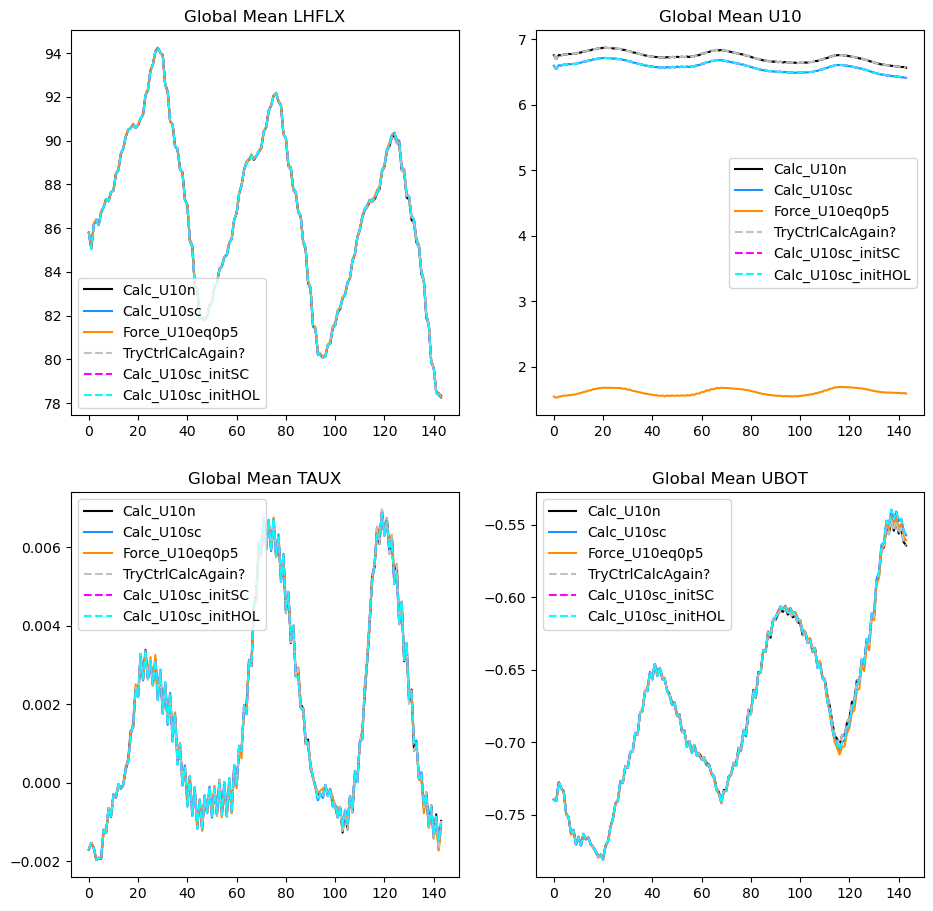

In [5]:
fig,axs = plt.subplots(2,2, figsize=(11,11))
axs = axs.ravel()

axs[0].plot(globalLHFLX.isel(case=0).values,'k', label=globalLHFLX.isel(case=0).case.values)
axs[0].plot(globalLHFLX.isel(case=1).values,color='dodgerblue', label=globalLHFLX.isel(case=1).case.values)
axs[0].plot(globalLHFLX.isel(case=2).values,color='darkorange', label=globalLHFLX.isel(case=2).case.values)
axs[0].plot(globalLHFLX.isel(case=3).values,'--', color='silver', label=globalLHFLX.isel(case=3).case.values)
axs[0].plot(globalLHFLX.isel(case=4).values,'--', color='magenta', label=globalLHFLX.isel(case=4).case.values)
axs[0].plot(globalLHFLX.isel(case=5).values,'--', color='cyan', label=globalLHFLX.isel(case=5).case.values)
axs[0].legend()
axs[0].set_title('Global Mean LHFLX')

axs[1].plot(globalU10.isel(case=0).values,'k', label=globalU10.isel(case=0).case.values)
axs[1].plot(globalU10.isel(case=1).values, color='dodgerblue', label=globalU10.isel(case=1).case.values)
axs[1].plot(globalU10.isel(case=2).values, color='darkorange', label=globalU10.isel(case=2).case.values)
axs[1].plot(globalU10.isel(case=3).values, '--', color='silver', label=globalU10.isel(case=3).case.values)
axs[1].plot(globalU10.isel(case=4).values, '--', color='magenta', label=globalU10.isel(case=4).case.values)
axs[1].plot(globalU10.isel(case=5).values, '--', color='cyan', label=globalU10.isel(case=5).case.values)
axs[1].legend()
axs[1].set_title('Global Mean U10')

axs[2].plot(globalTAUX.isel(case=0).values,'k', label=globalTAUX.isel(case=0).case.values)
axs[2].plot(globalTAUX.isel(case=1).values,color='dodgerblue',label=globalTAUX.isel(case=1).case.values)
axs[2].plot(globalTAUX.isel(case=2).values,color='darkorange',label=globalTAUX.isel(case=2).case.values)
axs[2].plot(globalTAUX.isel(case=3).values,'--',color='silver',label=globalTAUX.isel(case=3).case.values)
axs[2].plot(globalTAUX.isel(case=4).values,'--',color='magenta',label=globalTAUX.isel(case=4).case.values)
axs[2].plot(globalTAUX.isel(case=5).values,'--',color='cyan',label=globalTAUX.isel(case=5).case.values)
axs[2].legend()
axs[2].set_title('Global Mean TAUX')

axs[3].plot(globalUBOT.isel(case=0).values,'k', label=globalUBOT.isel(case=0).case.values)
axs[3].plot(globalUBOT.isel(case=1).values,color='dodgerblue', label=globalUBOT.isel(case=1).case.values)
axs[3].plot(globalUBOT.isel(case=2).values,color='darkorange', label=globalUBOT.isel(case=2).case.values)
axs[3].plot(globalUBOT.isel(case=3).values,'--',color='silver', label=globalUBOT.isel(case=3).case.values)
axs[3].plot(globalUBOT.isel(case=4).values,'--',color='magenta', label=globalUBOT.isel(case=4).case.values)
axs[3].plot(globalUBOT.isel(case=5).values,'--',color='cyan', label=globalUBOT.isel(case=5).case.values)
axs[3].legend()
axs[3].set_title('Global Mean UBOT')

# [a.set_xlim([100,135]) for a in axs]
# [a.set_xlim([0,48]) for a in axs]



## Plot snapshot?

In [8]:
import matplotlib as mpl

In [9]:
longrid, latgrid = np.meshgrid(h2_testU10['lon'], h2_testU10['lat'])


In [32]:
timeSel = 0

Actual time plotted:  0001-01-01 00:30:00
   For reference, run start time =  0001-01-01 00:30:00
Max Diff = 0.0e+00
Min Diff = 0.0e+00


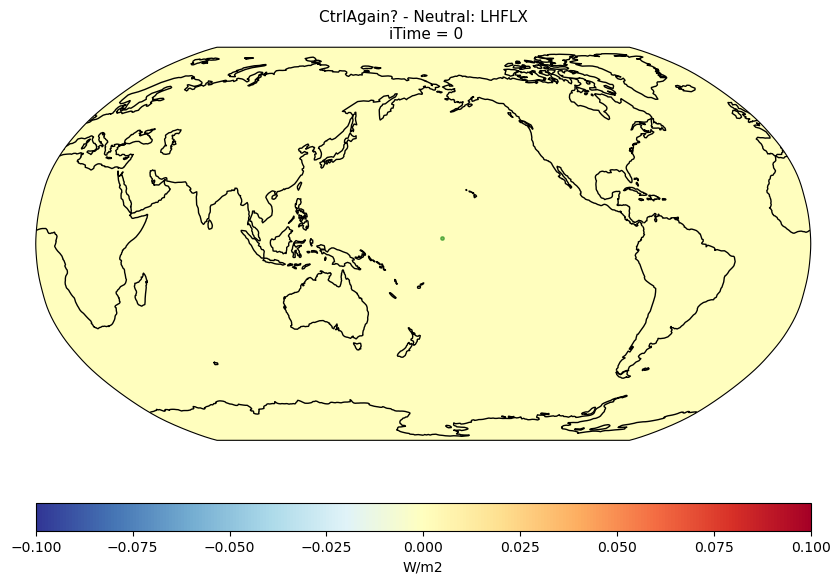

In [11]:
# timeSel = 50
varSel  = 'LHFLX'
unitStr  = 'W/m2'
diffDS  = h2_testU10[varSel].isel(time=timeSel, case=3) - h2_testU10[varSel].isel(time=timeSel, case=0)

print('Actual time plotted: ', diffDS.time.values)
print('   For reference, run start time = ', h2_testU10.isel(time=0).time.values)
print('Max Diff = %.1e\nMin Diff = %.1e' % (np.nanmax(diffDS),np.nanmin(diffDS)))

fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection":ccrs.Robinson(central_longitude=180)})

## Automate choosing colorbar limits 
diffVal = np.nanmax([np.abs(np.nanmax(diffDS)), np.abs(np.nanmin(diffDS))])*0.5
diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)

ax.pcolormesh(longrid, latgrid, diffDS.values, transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')

cax  = ax.inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)

ax.set_title('CtrlAgain? - Neutral: '+varSel+'\n iTime = '+str(timeSel), fontsize=11)
ax.coastlines()

ax.plot(diffDS.lon.sel(lon=189, method='nearest').values,
        diffDS.lat.sel(lat=2, method='nearest').values,'g.', markersize=5, alpha=0.5,transform=ccrs.PlateCarree())


plt.show()

Actual time plotted:  0001-01-01 00:30:00
   For reference, run start time =  0001-01-01 00:30:00
Max Diff = 0.0e+00
Min Diff = 0.0e+00


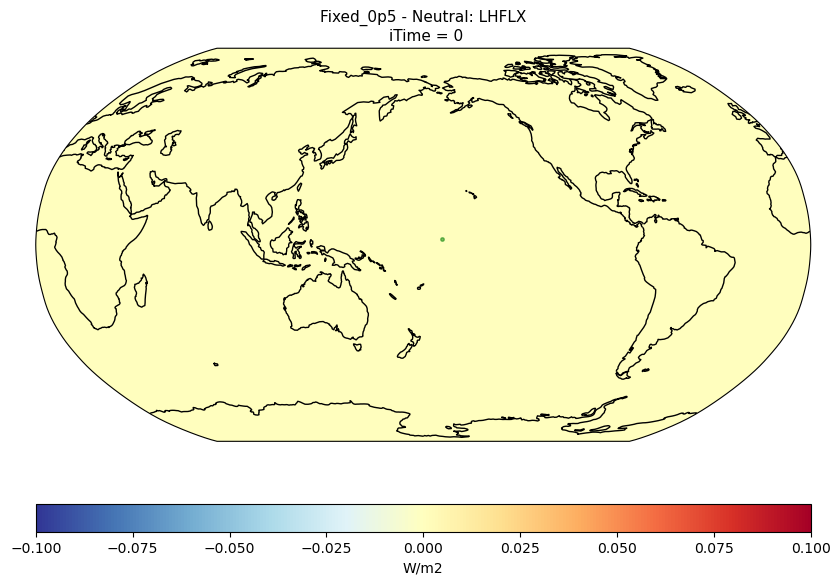

In [12]:
# timeSel = 50
varSel  = 'LHFLX'
unitStr  = 'W/m2'
diffDS  = h2_testU10[varSel].isel(time=timeSel, case=2) - h2_testU10[varSel].isel(time=timeSel, case=0)

print('Actual time plotted: ', diffDS.time.values)
print('   For reference, run start time = ', h2_testU10.isel(time=0).time.values)
print('Max Diff = %.1e\nMin Diff = %.1e' % (np.nanmax(diffDS),np.nanmin(diffDS)))

fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection":ccrs.Robinson(central_longitude=180)})

## Automate choosing colorbar limits 
diffVal = np.nanmax([np.abs(np.nanmax(diffDS)), np.abs(np.nanmin(diffDS))])*0.5
diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)

ax.pcolormesh(longrid, latgrid, diffDS.values, transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')

cax  = ax.inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)

ax.set_title('Fixed_0p5 - Neutral: '+varSel+'\n iTime = '+str(timeSel), fontsize=11)
ax.coastlines()

ax.plot(diffDS.lon.sel(lon=189, method='nearest').values,
        diffDS.lat.sel(lat=2, method='nearest').values,'g.', markersize=5, alpha=0.5,transform=ccrs.PlateCarree())


plt.show()

Actual time plotted:  0001-01-01 00:30:00
   For reference, run start time =  0001-01-01 00:30:00
Max Diff = 0.0e+00
Min Diff = 0.0e+00


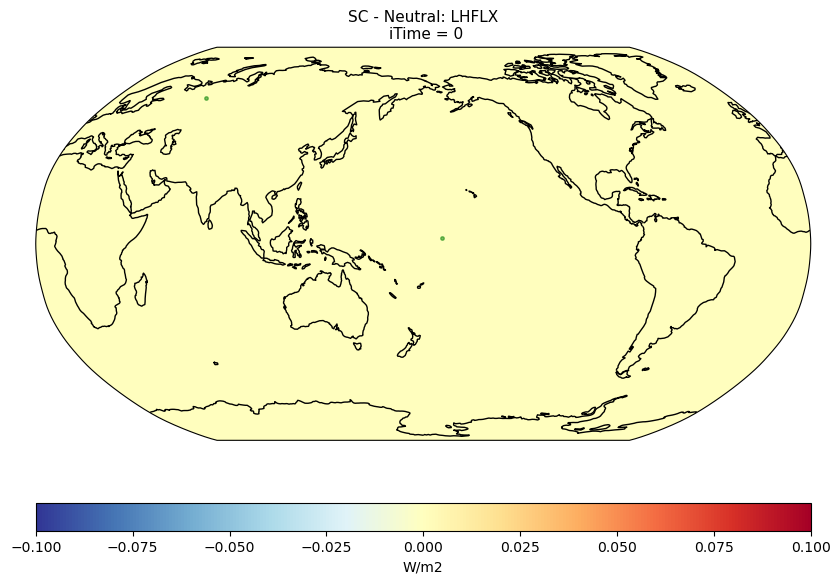

In [13]:
# timeSel = 50
varSel  = 'LHFLX'
unitStr  = 'W/m2'
diffDS  = h2_testU10[varSel].isel(time=timeSel, case=1) - h2_testU10[varSel].isel(time=timeSel, case=0)

print('Actual time plotted: ', diffDS.time.values)
print('   For reference, run start time = ', h2_testU10.isel(time=0).time.values)
print('Max Diff = %.1e\nMin Diff = %.1e' % (np.nanmax(diffDS),np.nanmin(diffDS)))

fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection":ccrs.Robinson(central_longitude=180)})

## Automate choosing colorbar limits 
diffVal = np.nanmax([np.abs(np.nanmax(diffDS)), np.abs(np.nanmin(diffDS))])*0.5
diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)

ax.pcolormesh(longrid, latgrid, diffDS.values, transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')

cax  = ax.inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)

ax.set_title('SC - Neutral: '+varSel+'\n iTime = '+str(timeSel), fontsize=11)
ax.coastlines()

ax.plot(diffDS.lon.sel(lon=189, method='nearest').values,
        diffDS.lat.sel(lat=2, method='nearest').values,'g.', markersize=5, alpha=0.5,transform=ccrs.PlateCarree())

ax.plot(diffDS.lon.sel(lon=52, method='nearest').values,
        diffDS.lat.sel(lat=61, method='nearest').values,'g.', markersize=5, alpha=0.5,transform=ccrs.PlateCarree())



plt.show()

Actual time plotted:  0001-01-01 00:30:00
   For reference, run start time =  0001-01-01 00:30:00
Max Diff = 1.3e+00
Min Diff = -8.9e-01


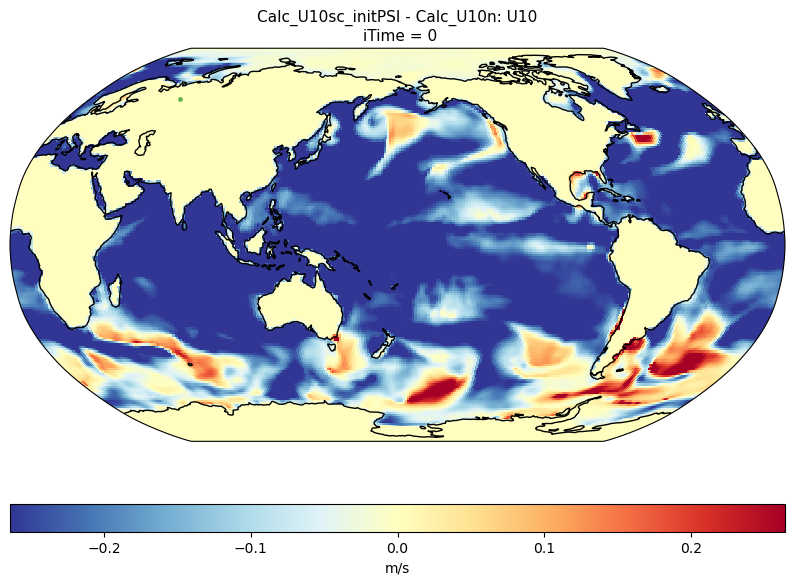

In [39]:
timeSel = 0
varSel  = 'U10'
unitStr  = 'm/s'
# diffDS  = h2_testU10[varSel].isel(time=timeSel, case=1) - h2_testU10[varSel].isel(time=timeSel, case=0)
# diffDS  = h2_testU10[varSel].isel(time=timeSel, case=1) - h2_testU10[varSel].isel(time=timeSel, case=2)
# diffDS  = h2_testU10[varSel].isel(time=timeSel, case=0) - h2_testU10[varSel].isel(time=timeSel, case=3)
diffDS  = h2_testU10[varSel].isel(time=timeSel, case=6) - h2_testU10[varSel].isel(time=timeSel, case=0)

print('Actual time plotted: ', diffDS.time.values)
print('   For reference, run start time = ', h2_testU10.isel(time=0).time.values)
print('Max Diff = %.1e\nMin Diff = %.1e' % (np.nanmax(diffDS),np.nanmin(diffDS)))

fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection":ccrs.Robinson(central_longitude=180)})

## Automate choosing colorbar limits 
diffVal = np.nanmax([np.abs(np.nanmax(diffDS)), np.abs(np.nanmin(diffDS))])*0.2
diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)

ax.pcolormesh(longrid, latgrid, diffDS.values, transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')

cax  = ax.inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)

ax.set_title(str(h2_testU10.isel(case=6).case.values)+' - '+
             str(h2_testU10.isel(case=0).case.values)+': '+varSel+'\n iTime = '+str(timeSel), fontsize=11)
ax.coastlines()

ax.plot(diffDS.lon.sel(lon=52, method='nearest').values,
        diffDS.lat.sel(lat=61, method='nearest').values,'g.', markersize=5, alpha=0.5,transform=ccrs.PlateCarree())

plt.show()

Actual time plotted:  0001-01-01 00:30:00
   For reference, run start time =  0001-01-01 00:30:00
Max Diff = 2.4e-04
Min Diff = -3.4e-04


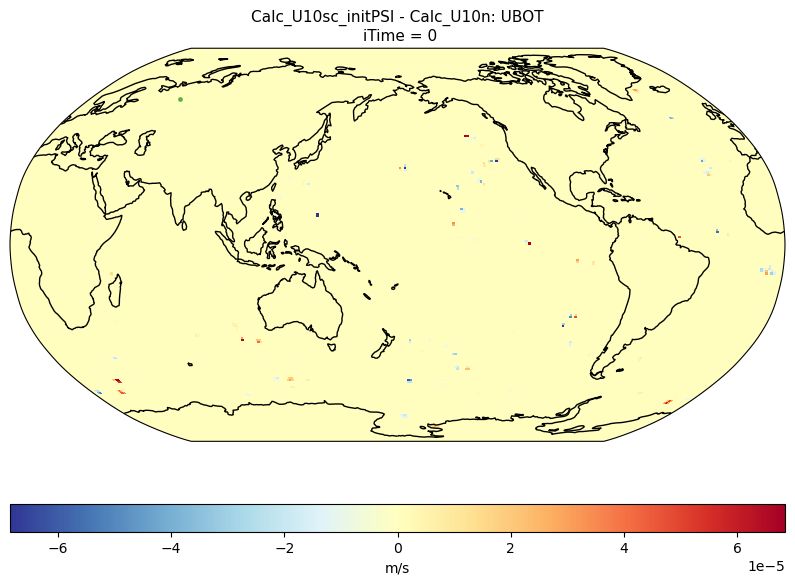

In [10]:
timeSel = 0
varSel  = 'UBOT'
unitStr  = 'm/s'
# diffDS  = h2_testU10[varSel].isel(time=timeSel, case=1) - h2_testU10[varSel].isel(time=timeSel, case=0)
# diffDS  = h2_testU10[varSel].isel(time=timeSel, case=1) - h2_testU10[varSel].isel(time=timeSel, case=2)
# diffDS  = h2_testU10[varSel].isel(time=timeSel, case=0) - h2_testU10[varSel].isel(time=timeSel, case=3)
diffDS  = h2_testU10[varSel].isel(time=timeSel, case=6) - h2_testU10[varSel].isel(time=timeSel, case=0)

print('Actual time plotted: ', diffDS.time.values)
print('   For reference, run start time = ', h2_testU10.isel(time=0).time.values)
print('Max Diff = %.1e\nMin Diff = %.1e' % (np.nanmax(diffDS),np.nanmin(diffDS)))

fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection":ccrs.Robinson(central_longitude=180)})

## Automate choosing colorbar limits 
diffVal = np.nanmax([np.abs(np.nanmax(diffDS)), np.abs(np.nanmin(diffDS))])*0.2
diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)

ax.pcolormesh(longrid, latgrid, diffDS.values, transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')

cax  = ax.inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)

ax.set_title(str(h2_testU10.isel(case=6).case.values)+' - '+
             str(h2_testU10.isel(case=0).case.values)+': '+varSel+'\n iTime = '+str(timeSel), fontsize=11)
ax.coastlines()

ax.plot(diffDS.lon.sel(lon=52, method='nearest').values,
        diffDS.lat.sel(lat=61, method='nearest').values,'g.', markersize=5, alpha=0.5,transform=ccrs.PlateCarree())

plt.show()

Actual time plotted:  0001-01-01 00:30:00
   For reference, run start time =  0001-01-01 00:30:00


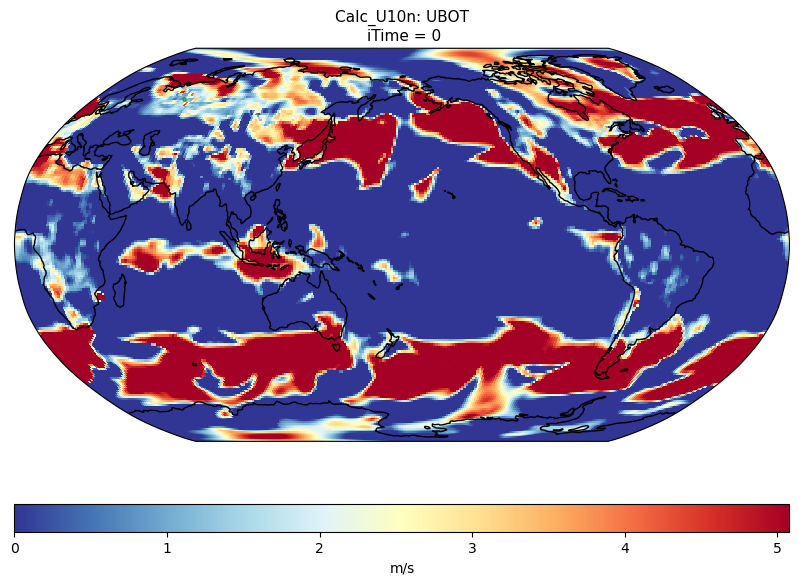

In [13]:
timeSel = 0
varSel  = 'UBOT'
unitStr  = 'm/s'
diffDS  = h2_testU10[varSel].isel(time=timeSel, case=0)

print('Actual time plotted: ', diffDS.time.values)
print('   For reference, run start time = ', h2_testU10.isel(time=0).time.values)

fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection":ccrs.Robinson(central_longitude=180)})

## Automate choosing colorbar limits 
diffVal = np.nanmax([np.abs(np.nanmax(diffDS))])*0.2
diff_norm = mpl.colors.Normalize(vmin=0, vmax=diffVal)

ax.pcolormesh(longrid, latgrid, diffDS.values, transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')

cax  = ax.inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)

ax.set_title(str(h2_testU10.isel(case=0).case.values)+': '+varSel+'\n iTime = '+str(timeSel), fontsize=11)
ax.coastlines()

ax.plot(diffDS.lon.sel(lon=52, method='nearest').values,
        diffDS.lat.sel(lat=61, method='nearest').values,'g.', markersize=5, alpha=0.5,transform=ccrs.PlateCarree())

plt.show()

In [ ]:
# timeSel = 50
varSel  = 'TAUX'
unitStr  = ''
diffDS  = h2_testU10[varSel].isel(time=timeSel, case=1) - h2_testU10[varSel].isel(time=timeSel, case=0)

print('Actual time plotted: ', diffDS.time.values)
print('   For reference, run start time = ', h2_testU10.isel(time=0).time.values)
print('Max Diff = %.1e\nMin Diff = %.1e' % (np.nanmax(diffDS),np.nanmin(diffDS)))

fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection":ccrs.Robinson(central_longitude=180)})

## Automate choosing colorbar limits 
diffVal = np.nanmax([np.abs(np.nanmax(diffDS)), np.abs(np.nanmin(diffDS))])*0.1
diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)

ax.pcolormesh(longrid, latgrid, diffDS.values, transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')

cax  = ax.inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)

ax.set_title('SC - Neutral: '+varSel+'\n iTime = '+str(timeSel), fontsize=11)
ax.coastlines()

plt.show()

In [ ]:
# timeSel = 50
varSel  = 'SHFLX'
unitStr  = ''
diffDS  = h2_testU10[varSel].isel(time=timeSel, case=1) - h2_testU10[varSel].isel(time=timeSel, case=0)

print('Actual time plotted: ', diffDS.time.values)
print('   For reference, run start time = ', h2_testU10.isel(time=0).time.values)
print('Max Diff = %.2f\nMin Diff = %.2f' % (np.nanmax(diffDS),np.nanmin(diffDS)))

fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection":ccrs.Robinson(central_longitude=180)})

## Automate choosing colorbar limits 
diffVal = np.nanmax([np.abs(np.nanmax(diffDS)), np.abs(np.nanmin(diffDS))])*0.5
diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)

ax.pcolormesh(longrid, latgrid, diffDS.values, transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')

cax  = ax.inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)

ax.set_title('SC - Neutral: '+varSel+'\n iTime = '+str(timeSel), fontsize=11)
ax.coastlines()

plt.show()

## Points where inic doesn't match for UBOT

Actual time plotted:  0001-01-01 00:30:00
   For reference, run start time =  0001-01-01 00:30:00
Max Diff = 5.8e-05
Min Diff = -2.5e-04


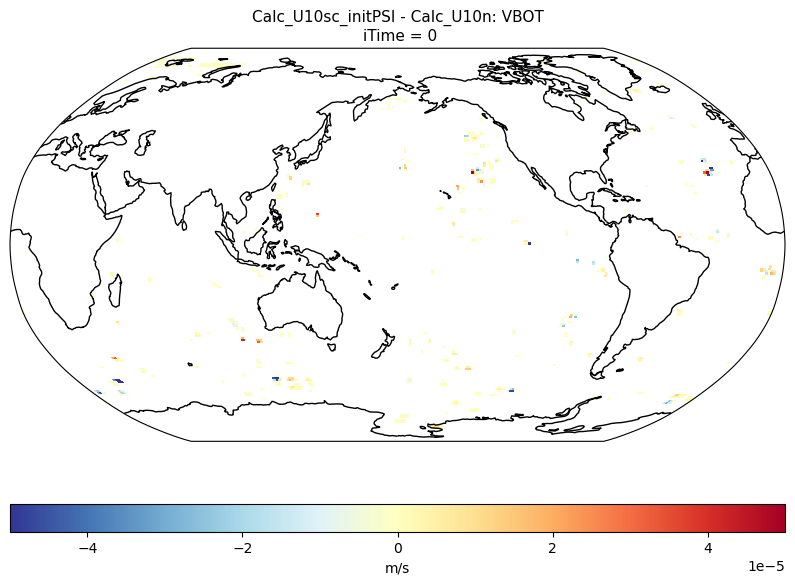

In [28]:
timeSel = 0
varSel  = 'UBOT'
unitStr  = 'm/s'
# diffDS  = h2_testU10[varSel].isel(time=timeSel, case=1) - h2_testU10[varSel].isel(time=timeSel, case=0)
# diffDS  = h2_testU10[varSel].isel(time=timeSel, case=1) - h2_testU10[varSel].isel(time=timeSel, case=2)
# diffDS  = h2_testU10[varSel].isel(time=timeSel, case=0) - h2_testU10[varSel].isel(time=timeSel, case=3)
diffDS  = h2_testU10[varSel].isel(time=timeSel, case=6) - h2_testU10[varSel].isel(time=timeSel, case=0)


print('Actual time plotted: ', diffDS.time.values)
print('   For reference, run start time = ', h2_testU10.isel(time=0).time.values)
print('Max Diff = %.1e\nMin Diff = %.1e' % (np.nanmax(diffDS),np.nanmin(diffDS)))

diffDS = diffDS.values
diffDS[np.where(diffDS==0)] = np.nan

fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection":ccrs.Robinson(central_longitude=180)})

## Automate choosing colorbar limits 
diffVal = np.nanmax([np.abs(np.nanmax(diffDS)), np.abs(np.nanmin(diffDS))])*0.2
diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)

ax.pcolormesh(longrid, latgrid, diffDS, transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')

cax  = ax.inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)

ax.set_title(str(h2_testU10.isel(case=6).case.values)+' - '+
             str(h2_testU10.isel(case=0).case.values)+': '+varSel+'\n iTime = '+str(timeSel), fontsize=11)
ax.coastlines()

# ax.plot(diffDS.lon.sel(lon=52, method='nearest').values,
#         diffDS.lat.sel(lat=61, method='nearest').values,'g.', markersize=5, alpha=0.5,transform=ccrs.PlateCarree())

plt.show()

In [11]:
diffDS  = h2_testU10['UBOT'].isel(time=timeSel, case=6) - h2_testU10['UBOT'].isel(time=timeSel, case=0)

probPointMask = np.zeros([len(diffDS.lat.values), len(diffDS.lon.values)])
probPointMask[np.where(diffDS.values!=0)] = 1


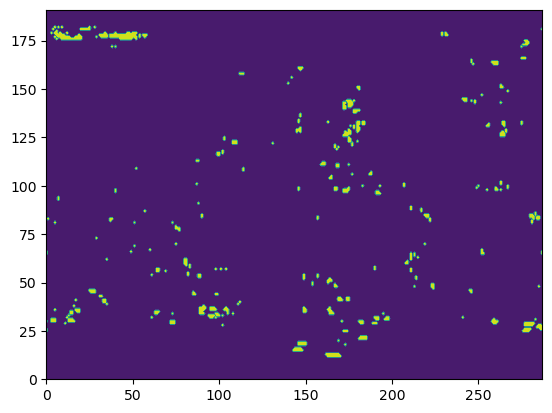

In [12]:
plt.contourf(probPointMask)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00, 9.0000e+00,
        1.4000e+01, 1.8000e+01, 2.2000e+01, 9.0000e+01, 5.5032e+04,
        2.9000e+01, 1.4000e+01, 1.6000e+01, 7.0000e+00, 8.0000e+00,
        3.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 0.00

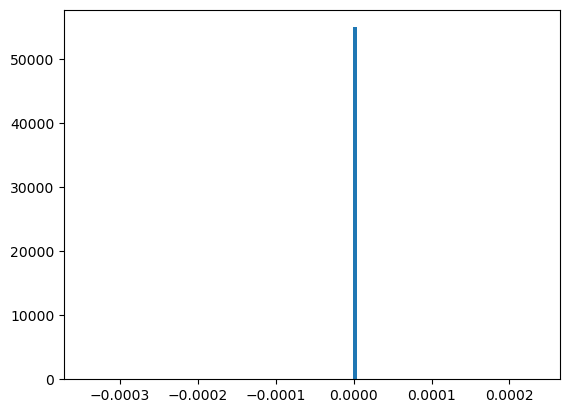

In [24]:
plt.hist(diffDS.values.reshape([len(h2_testU10.lat.values)*len(h2_testU10.lon.values), 1]), 
        100)

In [13]:
timeSelDS = h2_testU10.isel(time=0, case=5)
timeSelDS['probPointMask'] = (('lat','lon'), probPointMask)

selProbPoints_case5 = timeSelDS.where(timeSelDS.probPointMask==1)
selGoodPoints_case5 = timeSelDS.where(timeSelDS.probPointMask==0)

In [58]:
latProb = selProbPoints_case5.mean(dim='lon')
latGood = selGoodPoints_case5.mean(dim='lon')

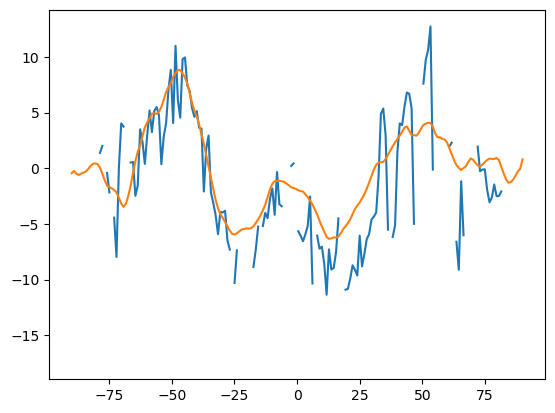

In [59]:
plt.plot(latProb.lat.values, latProb.UBOT.values)
plt.plot(latGood.lat.values, latGood.UBOT.values)

In [54]:
selProbPoints_case5

<xarray.Dataset>
Dimensions:        (lat: 192, lon: 288, lev: 58, ilev: 59, nbnd: 2,
                    trop_cld_lev: 58)
Coordinates:
  * lat            (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon            (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.3 357.5 358.8
  * lev            (lev) float64 3.018 5.445 9.087 14.25 ... 983.2 991.2 997.5
  * ilev           (ilev) float64 2.055 3.98 6.909 11.27 ... 987.4 995.1 1e+03
  * trop_cld_lev   (trop_cld_lev) float64 3.018 5.445 9.087 ... 991.2 997.5
    time           object 0001-01-01 00:30:00
    case           <U18 'TryCtrlCalcAgain?'
Dimensions without coordinates: nbnd
Data variables: (12/33)
    w              (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    hyam           (lev, lat, lon) float64 dask.array<chunksize=(58, 192, 288), meta=np.ndarray>
    hybm           (lev, lat, lon) float64 dask.array<chunksize=(58, 192, 288), meta=np.ndarray>
    hyai           (ilev, lat, lon) float64 dask.array<chunksize=(59, 192, 288), meta=np.ndarray>
    hybi           (ilev, lat, lon) float64 dask.array<chunksize=(59, 192, 288), meta=np.ndarray>
    date           (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ...             ...
    TAUY           (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    U10            (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    UBOT           (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    UGUST          (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    VBOT           (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    probPointMask  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    interp_type:       bilinear
    interp_outputgri:  equally spaced with poles
    Conventions:       CF-1.0
    source:            CAM
    case:              FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_ces...
    logname:           mdfowler
    host:              derecho1
    initial_file:      f.cam6_3_107.FLTHIST_v0a.ne30.clm5_1.001.cam.i.1994-01...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/s...
    model_doi_url:     not_set
    time_period_freq:  minute_30

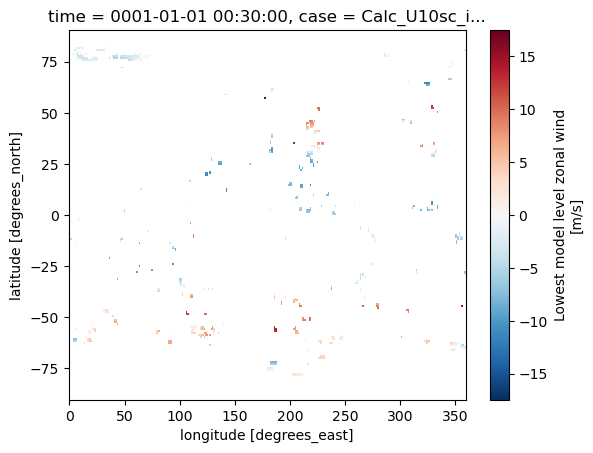

In [14]:
selProbPoints_case5.UBOT.plot()

In [15]:
timeSelDS_5 = h2_testU10.isel(time=0, case=5)
timeSelDS_5['probPointMask'] = (('lat','lon'), probPointMask)

selProbPoints_case5 = timeSelDS_5.where(timeSelDS_5.probPointMask==1)
selGoodPoints_case5 = timeSelDS_5.where(timeSelDS_5.probPointMask==0)



In [16]:
timeSelDS_0 = h2_testU10.isel(time=0, case=0)
timeSelDS_0['probPointMask'] = (('lat','lon'), probPointMask)

selProbPoints_case0 = timeSelDS_0.where(timeSelDS_0.probPointMask==1)
selGoodPoints_case0 = timeSelDS_0.where(timeSelDS_0.probPointMask==0)



In [29]:
print('           UBOT      ')
print('CTRL            TEST            DIFF')
print('-----           -----          ------')

ivalPoints = 693 ## second dimension of np.shape(np.where(np.isfinite(selProbPoints_case5.UBOT.values)))
# ivalPoints = 20 ## second dimension of np.shape(np.where(np.isfinite(selProbPoints_case5.UBOT.values)))

for i in range(ivalPoints):
    ctrlPoint = selProbPoints_case0.UBOT.values[np.where(np.isfinite(selProbPoints_case0.UBOT.values))][i]
    testPoint = selProbPoints_case5.UBOT.values[np.where(np.isfinite(selProbPoints_case5.UBOT.values))][i]
    print('%2.8f %13.8f %13.8f' % (ctrlPoint,testPoint,testPoint-ctrlPoint))


           UBOT      
CTRL            TEST            DIFF
-----           -----          ------
1.90853477    1.90853918    0.00000441
1.79628968    1.79630208    0.00001240
1.66857207    1.66858971    0.00001764
1.52456772    1.52458811    0.00002038
1.36351359    1.36353421    0.00002062
1.15167212    1.15168405    0.00001192
0.93210071    0.93210602    0.00000530
0.70695704    0.70695829    0.00000125
2.50893092    2.50893283    0.00000191
2.42149544    2.42150164    0.00000620
2.32478714    2.32480025    0.00001311
2.21851349    2.21853590    0.00002241
2.02577543    2.02579737    0.00002193
1.80085731    1.80087543    0.00001812
1.54808033    1.54809213    0.00001180
1.26763868    1.26764190    0.00000322
-0.62812841   -0.62812829    0.00000012
-0.55850881   -0.55850846    0.00000036
-0.48702967   -0.48702905    0.00000063
-0.39308351   -0.39308286    0.00000066
-0.26557437   -0.26557395    0.00000042
-0.13310602   -0.13310586    0.00000016
-2.19937229   -2.19937205    0.00000024

In [18]:
np.shape(np.where(np.isfinite(selProbPoints_case5.UBOT.values)))

(2, 693)

In [35]:
selProbPoints_case5.UBOT.values[np.where(np.isfinite(selProbPoints_case5.UBOT.values))]

array([ 1.90853918e+00,  1.79630208e+00,  1.66858971e+00,  1.52458811e+00,
        1.36353421e+00,  1.15168405e+00,  9.32106018e-01,  7.06958294e-01,
        2.50893283e+00,  2.42150164e+00,  2.32480025e+00,  2.21853590e+00,
        2.02579737e+00,  1.80087543e+00,  1.54809213e+00,  1.26764190e+00,
       -6.28128290e-01, -5.58508456e-01, -4.87029046e-01, -3.93082857e-01,
       -2.65573949e-01, -1.33105859e-01, -2.19937205e+00, -2.19804788e+00,
       -2.17333722e+00, -2.12536383e+00, -5.88337755e+00, -5.98343229e+00,
       -6.06512547e+00, -6.04550505e+00, -6.00766754e+00,  3.39062452e+00,
       -7.79709053e+00, -7.94415283e+00, -8.03852463e+00, -8.04427624e+00,
       -8.01684475e+00, -2.28714421e-02,  3.93986320e+00,  3.99509883e+00,
        4.03043365e+00,  4.04799891e+00,  4.16330862e+00,  3.58988762e+00,
        3.70670485e+00,  3.78322673e+00,  3.91676331e+00,  1.50454016e-02,
       -2.08489275e+00, -1.02146888e+00, -1.09065041e-01,  8.17045808e-01,
        1.66434658e+00,  

In [34]:
selProbPoints_case0.UBOT.values[np.where(np.isfinite(selProbPoints_case0.UBOT.values))]

array([ 1.90853477e+00,  1.79628968e+00,  1.66857207e+00,  1.52456772e+00,
        1.36351359e+00,  1.15167212e+00,  9.32100713e-01,  7.06957042e-01,
        2.50893092e+00,  2.42149544e+00,  2.32478714e+00,  2.21851349e+00,
        2.02577543e+00,  1.80085731e+00,  1.54808033e+00,  1.26763868e+00,
       -6.28128409e-01, -5.58508813e-01, -4.87029672e-01, -3.93083513e-01,
       -2.65574366e-01, -1.33106023e-01, -2.19937229e+00, -2.19804835e+00,
       -2.17333770e+00, -2.12536407e+00, -5.88337326e+00, -5.98342180e+00,
       -6.06511068e+00, -6.04549694e+00, -6.00766468e+00,  3.39062428e+00,
       -7.79708338e+00, -7.94413662e+00, -8.03850365e+00, -8.04426384e+00,
       -8.01684284e+00, -2.28714403e-02,  3.93986344e+00,  3.99509978e+00,
        4.03043509e+00,  4.04800034e+00,  4.16330910e+00,  3.58988810e+00,
        3.70670581e+00,  3.78322744e+00,  3.91676354e+00,  1.50454007e-02,
       -2.08489299e+00, -1.02146900e+00, -1.09065063e-01,  8.17043424e-01,
        1.66431570e+00,  

## Pick a point

In [41]:
# pointDS =  h2_testU10.sel(lon=189, lat=2, method='nearest')
pointDS =  h2_testU10.sel(lon=52, lat=61, method='nearest')


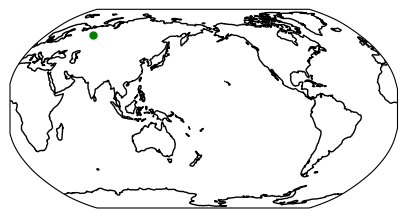

In [42]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={"projection":ccrs.Robinson(central_longitude=180)})
ax.plot(pointDS.lon.values, pointDS.lat.values, 'go', markersize=5, transform=ccrs.PlateCarree())

ax.coastlines()
ax.set_extent([0,358,-89,89])


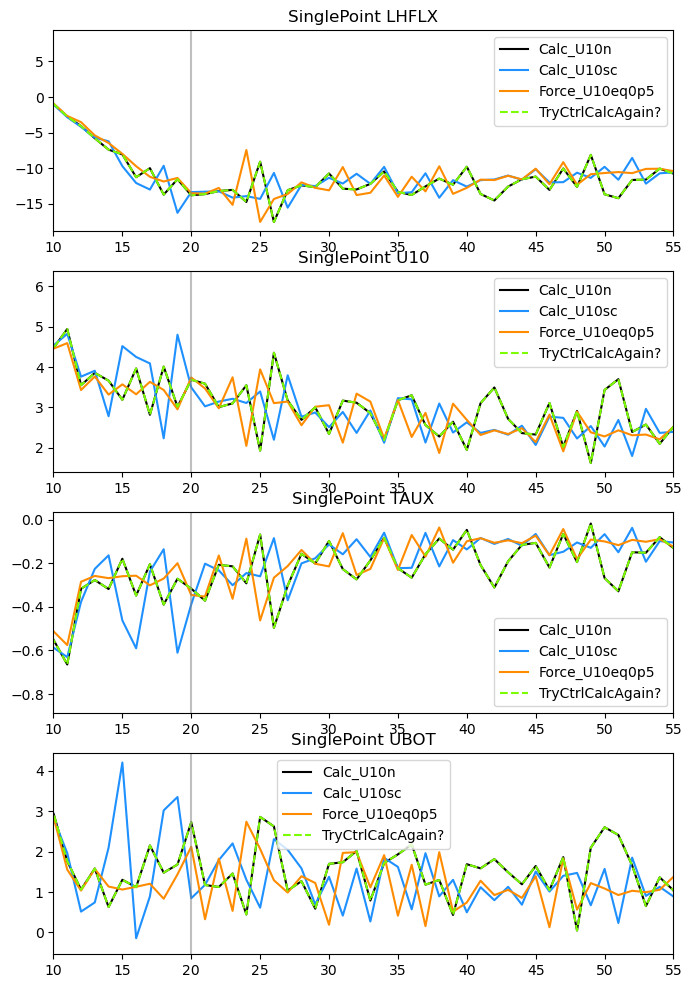

In [43]:
fig,axs = plt.subplots(4,1, figsize=(8,12))
axs = axs.ravel()

axs[0].plot(pointDS['LHFLX'].isel(case=0).values,'k', label=pointDS.isel(case=0).case.values)
axs[0].plot(pointDS['LHFLX'].isel(case=1).values,color='dodgerblue', label=pointDS.isel(case=1).case.values)
axs[0].plot(pointDS['LHFLX'].isel(case=2).values,color='darkorange', label=pointDS.isel(case=2).case.values)
axs[0].plot(pointDS['LHFLX'].isel(case=3).values,'--',color='lawngreen', label=pointDS.isel(case=3).case.values)
axs[0].legend()
axs[0].set_title('SinglePoint LHFLX')

axs[1].plot(pointDS['U10'].isel(case=0).values,'k', label=pointDS.isel(case=0).case.values)
axs[1].plot(pointDS['U10'].isel(case=1).values, color='dodgerblue', label=pointDS.isel(case=1).case.values)
axs[1].plot(pointDS['U10'].isel(case=2).values, color='darkorange', label=pointDS.isel(case=2).case.values)
axs[1].plot(pointDS['U10'].isel(case=3).values, '--', color='lawngreen', label=pointDS.isel(case=3).case.values)
axs[1].legend()
axs[1].set_title('SinglePoint U10')

axs[2].plot(pointDS['TAUX'].isel(case=0).values,'k', label=pointDS.isel(case=0).case.values)
axs[2].plot(pointDS['TAUX'].isel(case=1).values,color='dodgerblue',label=pointDS.isel(case=1).case.values)
axs[2].plot(pointDS['TAUX'].isel(case=2).values,color='darkorange',label=pointDS.isel(case=2).case.values)
axs[2].plot(pointDS['TAUX'].isel(case=3).values,'--',color='lawngreen',label=pointDS.isel(case=3).case.values)
axs[2].legend()
axs[2].set_title('SinglePoint TAUX')

axs[3].plot(pointDS['UBOT'].isel(case=0).values,'k', label=pointDS.isel(case=0).case.values)
axs[3].plot(pointDS['UBOT'].isel(case=1).values,color='dodgerblue', label=pointDS.isel(case=1).case.values)
axs[3].plot(pointDS['UBOT'].isel(case=2).values,color='darkorange', label=pointDS.isel(case=2).case.values)
axs[3].plot(pointDS['UBOT'].isel(case=3).values,'--',color='lawngreen', label=pointDS.isel(case=3).case.values)
axs[3].legend()
axs[3].set_title('SinglePoint UBOT')

[a.set_xlim([10,55]) for a in axs]
[a.axvline(20, color='grey',alpha=0.5) for a in axs]

# axs[2].set_ylim([0.01,0.04])
# axs[3].set_ylim([-5,-3])


## SCAM

In [18]:
dataDir = '/glade/derecho/scratch/mdfowler/archive/'

caseNames = ['FSCAM.T42_T42.TestGustSCAM_gustsOFF.U10scToAtm.005_neutVersion_DYCOMSrf01',
             'FSCAM.T42_T42.TestGustSCAM_gustsOFF.U10scToAtm.005_scVersion_DYCOMSrf01',
            ]

case_IDs = ['Calc_U10n', 'Calc_U10sc']


In [19]:
for iCase in range(len(case_IDs)):
    # print('*** Starting on case %s ***' % (case_IDs[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(dataDir+caseNames[iCase]+'/atm/hist/*cam.h0i.*-*'))
    listFiles_h2 = np.sort(glob.glob(dataDir+caseNames[iCase]+'/atm/hist/*cam.h2i.*-*'))
    
    ## Now read in those files    
    case_h0 = xr.open_mfdataset(listFiles_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
    
    case_h2 = xr.open_mfdataset(listFiles_h2, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
        
    ## Add case ID (short name) to the DS
    case_h0      = case_h0.squeeze().assign_coords({"case":  case_IDs[iCase]})
    case_h2      = case_h2.squeeze().assign_coords({"case":  case_IDs[iCase]})

    print(case_IDs[iCase], ' .... TimeEnd = ', case_h2.isel(time=-1).time.values)
    
    ## Return all the cases in a single dataset  
    if iCase==0:
        h0_testU10 = case_h0
        h2_testU10 = case_h2
    else: 
        h0_testU10 = xr.concat([h0_testU10, case_h0], "case") 
        h2_testU10 = xr.concat([h2_testU10, case_h2], "case") 


Calc_U10n  .... TimeEnd =  1999-07-13 00:00:00
Calc_U10sc  .... TimeEnd =  1999-07-13 00:00:00


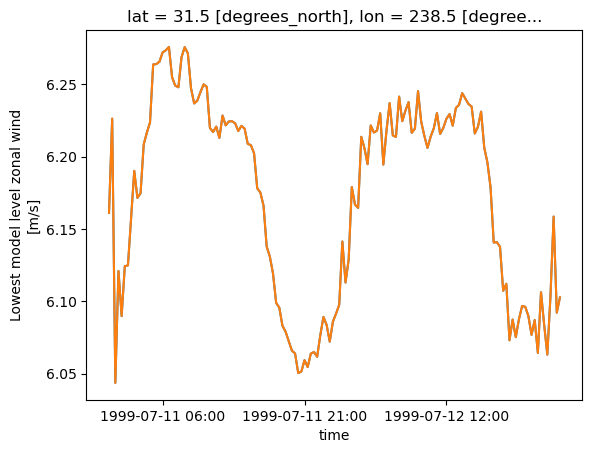

In [20]:
h2_testU10.UBOT.isel(case=0).plot()
h2_testU10.UBOT.isel(case=1).plot()

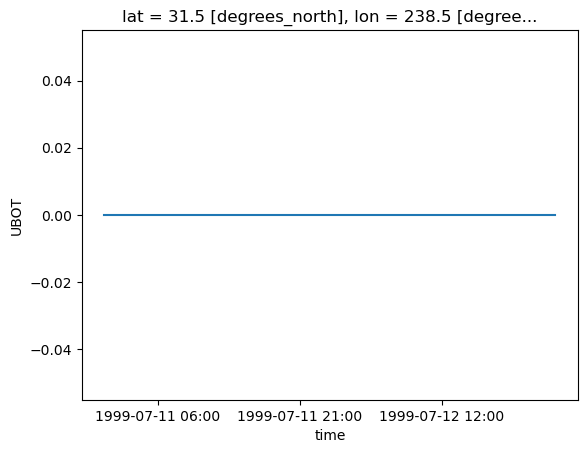

In [21]:
(h2_testU10.UBOT.isel(case=1) - h2_testU10.UBOT.isel(case=0)).plot()


In [22]:
(h2_testU10.UBOT.isel(case=1) - h2_testU10.UBOT.isel(case=0)).min().values


array(0., dtype=float32)

In [23]:
(h2_testU10.UBOT.isel(case=1) - h2_testU10.UBOT.isel(case=0)).max().values


array(0., dtype=float32)